In [91]:
import csv
import decimal
import math
from functools import cache
from itertools import accumulate
# from sympy.utilities.lambdify import lambdify, implemented_function
from operator import add

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy as sc
import scipy.integrate as integrate
import scipy.optimize as optimize
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import axes3d
from numpy import cos, cosh, exp, pi, sin, sinh

import pandas as pd



In [92]:
# Helpt dit?
def function_operation(h, f, g):
    return lambda z: h(f(z), g(z))


def scalar_multiplication(s, f):
    return lambda z: s * f(z)


def multiplication(f, g):
    return lambda z: math.prod([func(z) for func in [f, g]])

def integral(func, a, b):
    return integrate.quad(func, a=a, b=b, limit=100)[0]

In [93]:

sea_model = {
    "mild": (5.7, 1.5, 33.8),
    "medium": (8.6, 4.1, 76.5),
    "rough": (11.4, 8.5, 136),
}

wave_period, wave_amplitude, wave_length = sea_model["mild"]

# (Radian) frequency: ?
sigma = (2 * np.pi) / wave_period

# Radi
R_Outer_Shell = 5 / 2
R_Inner_Shell = 3 / 2
D_Shell = 0.15

# Area Moment of inertia
I_Iron = pi / 4 * (R_Outer_Shell**4 - (R_Outer_Shell - D_Shell) ** 4) + pi / 4 * (
    (R_Inner_Shell + D_Shell) ** 4 - (R_Inner_Shell) ** 4
)
I_Concrete = pi / 4 * ((R_Outer_Shell - D_Shell) ** 4 - (R_Inner_Shell + D_Shell) ** 4)

I = I_Iron + I_Concrete
EI = (I_Iron) * 210 * 10**9 + I_Concrete * 20 * 10**9

# To calculate the density
A_Steel = pi * (R_Outer_Shell**2 - (R_Outer_Shell - D_Shell) ** 2) + pi * (
    (R_Inner_Shell + D_Shell) ** 2 - (R_Inner_Shell) ** 2
)
A_Concrete = pi * ((R_Outer_Shell - D_Shell) ** 2 - (R_Inner_Shell + D_Shell) ** 2)
A_Air = pi * (R_Inner_Shell) ** 2
A_Total = pi * (R_Outer_Shell) ** 2

# Density of the material
rho_steel = 7850
rho_concrete = 2300
rho_air = 1.225
rho_material = (
    A_Steel * rho_steel + A_Concrete * rho_concrete + A_Air * rho_air
) / A_Total

# density of water
rho_water = 1030

# Cilinder surface intersection
A = pi * (R_Outer_Shell) ** 2 - pi * (R_Inner_Shell) ** 2

# Kappa coefficient: 2 * pi / wave_length
kappa = 2 * np.pi / wave_length


# Water Density: 1025 kg/m^3
rho_water = 1025

# Inertia coefficient: 1+C_a ~ 8.66
# C_m = 8.66
C_m = 1.5

# Drag coefficient: 1.17
C_D = 1.17

# Cylinder diameter: ?
D = 5

# Distance from sea to seabed: 50m
H = 50

# l Length of the windmill 150
l = 150

# Temperature?
T = 20

In [94]:
# Eigenvalue function
@cache
def frequency_equation(x: float, l: float = 150.0) -> float:
    return (np.exp(x * l) + np.exp(-x * l)) / 2 * np.cos(x * l) + 1

# Returns the roots for the eigenvalue function
@cache
def find_lambdas(func, n):

    counter = 0
    zeros = []
    stepsize = (0.3043077 * 1.1) / 10000
    A = 0
    B = stepsize
    while counter < n:
        A += stepsize
        B += stepsize
        if func(A) * func(B) < 0:
            zeros.append(optimize.bisect(func, A, B))
            counter += 1
    return zeros

In [95]:
# * funtion that calculates the beta used in the document for some lambda
def beta_lambda_n(lambda_n) -> float:
    return (rho_material * A * lambda_n**4) / (EI)

In [96]:
# * The function to caculate the space dependent part of the SOV
@cache
def Z_n(lambda_n: float = 1.0, *args):
    wn = lambda_n * l
    shinh_wn = sinh(wn)
    cosh_wn = cosh(wn)
    C_n = (cosh_wn + cos(wn)) / (shinh_wn + sin(wn))
    res = (
        lambda z: ((1 - C_n) * exp(lambda_n * z) + (1 + C_n) * exp(-lambda_n * z)) / 2.0
        + C_n * sin(lambda_n * z)
        - cos(lambda_n * z)
    )
        # ! Error Checker
    # print(
    #     f"The value for lambda_n is \n {lambda_n} \n which provides a value fo C_n of:{C_n}\n"
    # )
    return res

In [97]:
T
@cache
def Q_n(lambda_n, rho_water=rho_water, A=A, T=T):

    # A = (pi / 4) * rho_water * C_m * D**2 * sigma**2 * a
    # * introduced constants:
    k = kappa

    # # * u is the function for the wave forcing. Here initialized as lambda function
    # u_drag = lambda z: (
    #     (np.exp(kappa * (z + H)) + np.exp(-kappa * (z + H))) / 2 if z <= 50 else 0
    # )

    # * Z_eq is the function for this lambda
    Z_eq = Z_n(lambda_n=lambda_n)

    # * ## Inertia Calculations ## * #

    # * Inertia part for Q
    # * Integrate the u_inertia. It remains constant for t.
    D_inertia_const = integral(
        lambda z: (exp(k * (z)) + exp(-k * (z))) / 2 * Z_eq(z), 0, H
    )
    C_inert = (
        -D_inertia_const * A * rho_water * C_m * sigma**2 * wave_amplitude / sinh(k * H)
    )

    # ! Error Checker
    # print(f"The C_inert is {C_inert}\n")

    # * The inertia itself is dependent on t. So it is put in a lambda function
    D_inertia = lambda t: C_inert * sin(sigma * t)

    # * ## Drag Calculations ## * #
    D_Drag_const = integral(
        lambda z: ((1 / 4) * exp(k * (z)) + exp(-k * (z))) ** 2 * Z_eq(z),
        a=0,
        b=H,
    )
    C_drag = (
        D_Drag_const
        * (1 / 2)
        * rho_water
        * C_D
        * D
        * sigma
        * wave_amplitude
        / (sinh(k * H)) ** 2
    )

    # ! Error Check
    # print(f"The values for D_Drag_const is {D_Drag_const}\n")

    # * Integrate the u_drag. It remains constant for t
    D_Drag = lambda t: C_drag * cos(sigma * t) * abs(cos(sigma * t))

    # * Return the sum of both functions
    Q = function_operation(add, D_inertia, D_Drag)

    return Q

In [98]:

# ? Function needs to be created top level in order to not be overwritten
@cache
def a_n(mu_n, a_const, n, Q_n):
    # * Return time dependent part of the sov
    # ! Error Check
    # val = integrate.quad(lambda tau: Q_n(tau) * np.sin(mu_n * tau), a=0, b=1, limit=300)
    # print(f"hey this is the value for this A_N's constant cos part at one second {val}")
    return lambda t, n=n: a_const * (
        np.sin(mu_n * t)
        * integrate.quad(
            lambda tau: Q_n(tau) * np.cos(mu_n * tau), a=0, b=t, limit=300
        )[0]
        - np.cos(mu_n * t)
        * integrate.quad(
            lambda tau: Q_n(tau) * np.sin(mu_n * tau), a=0, b=t, limit=300
        )[0]
    )

In [99]:
# ? Constants used in the BEQ
def b_list(lambda_list: list):
    b = []

    for lambda_n in lambda_list:
        Zn = Z_n(lambda_n=lambda_n)
        Zn_squared = multiplication(Zn, Zn)

        b.append(integral(Zn_squared, a=0, b=l))

        # ! Error Checker

    return b

In [100]:
# ? Beam equation. Combines all afformentioned functions.
def BEQ(
    t_end: float = 5,
    dt: float = 1,
    l: int = 150,
    dl: float = 15,
    A=A,
    rho_water=rho_water,
    T=T,
) -> list:
    # * Constants
    # A = np.pi * (D / 2) ** 2

    # # ! Error Checker
    # print(f"Creating a list of eigenvalues")
    lambda_list = find_lambdas(frequency_equation, 5)

    # ! Error Checker
    # print(f"amount of lambdas is {len(lambda_list)}")
    # print(f"\n The lambdas are: \n {lambda_list}")

    # * initialize heights and time_steps to be used in for loops
    heights = np.arange(0, l + dl, dl)
    time_steps = np.arange(0, t_end + dt, dt)

    # * Z_n_list of the space dependent parts of the SOV
    # * W_total is used to store the final result
    # * a_n_list stores the values for the time dependent part of th SOV
    # * b are constant values dependent on lambda
    Z_n_list = []  # list(function)
    W_total = (
        []
    )  # [ [time1,[ [x1,z1], [x2,z2],...  ]],[time2,[ [x1,z1], [x2,z2],...  ]],...  ]
    a_n_list = []  # list(floats)

    b = b_list(lambda_list)

    # # ! Error Checker
    # print(f"Creating a list for Z_n and a_n")
    # * Calculate all the values for the space dependent parts and
    # * the correspoinding time dependent functions for each lambda.
    for count, lambda_n in enumerate(lambda_list):

        # * Z_n_list contains the funciton Z_n as lambda functions
        # ? Parameters: z
        Z_n_list.append(Z_n(lambda_n=lambda_n))

        # * constants:
        # * mu_n dependent on lambda,
        # * A, B constants
        # * a_const dependent on lambdas
        mu_n = (lambda_n) ** 2 * np.sqrt(EI / (rho_material * A))
        # A_an = np.pi * rho_water * C_m * D**2
        # B_an = (1 / 2) * rho_water * C_D * D
        a_const = 1 / (rho_material * A * mu_n * b[count])

        # * a_n_list constains lambda functions of a_n(t). Input for the functions is t
        a_n_list.append(
            a_n(
                a_const=a_const,
                mu_n=mu_n,
                n=count,
                Q_n=Q_n(lambda_n=lambda_n, rho_water=rho_water),
            )
        )

    # ! Error checkers
    # print(f"\nthe first value for Z_n at the top is \n {(Z_n_list[0])(150)}\n")
    # print(f"the first a_n is {print(a_n[0])}")
    # print(f"\nthe list of lambda's is \n {lambda_list}\n")

    # * structure of output for the function BEQ
    # [ [time1,[ [x1,z1], [x2,z2],...  ]],[time2,[ [x1,z1], [x2,z2],...  ]],...  ]

    for t_step in time_steps:

        # ! Error checker
        # print(f"t_step ={t_step}")

        # * Initialize lambda function for the deviation
        W = lambda z: 0

        for count, lambda_n in enumerate(lambda_list):
            # * compute formula of Deviation U at time t

            # ! Error checker
            # print(f"count is given by number {count}")

            # * calculates the time dependent part of the SOV
            # * This is constant for all z so its constant for this t_step
            a_lambda = (a_n_list[count])(t_step, count)

            # * Time dependent part of SOV
            Z_lambda = Z_n_list[count]

            # ! Error checker a_lambda and z_lambda
            # print(f"a_lambda is {a_lambda} ")
            # print(f"z_lambda(150) is {Z_lambda(150)} ")

            # ! Error checker
            # print(f"Z_n in the function for input 10 provides {(zn)(z=10)}")

            # * W_n is the multiplied of the time and space dependent parts
            # * of the SOV. W is the sum of those values. Both are stored as lambda funcitons
            W_lambda = scalar_multiplication(a_lambda, Z_lambda)
            W = function_operation(add, W_lambda, W)

        # ! Error checker
        # print(f"W at the top of the beam is is {W(H)}")
        for h in heights:

            W_total.append([t_step, h, W(h)])

    return W_total

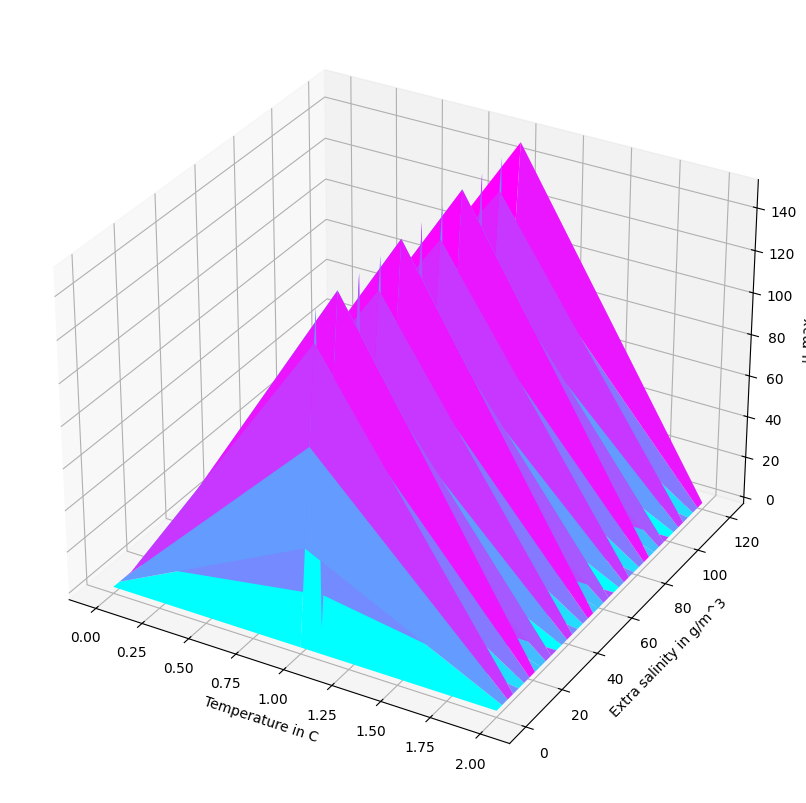

In [104]:
data = BEQ(t_end=10, dt=1, l=150)



df = pd.DataFrame(data)

Y = range(df.shape[0])
X = range(df.shape[1])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, df, cmap="cool")

ax.set_xlabel("Temperature in C")
ax.set_ylabel("Extra salinity in g/m^3")
ax.set_zlabel("u_max")

plt.show()

In [85]:
@cache
def max_dev(rho_w=rho_water, t_end=10):
    dt = 1
    l = 150
    dl = 10

    U_t = BEQ(t_end=t_end, dt=dt, l=l, dl=dl, rho_water=rho_w, T=T)
    bigollist = []
    max_val = 0

    for bop in U_t:
        bigollist.append(bop[2])

    bigollist.sort()

    max_val = (bigollist)[-1]
    min_val = (bigollist)[0]
    return max(abs(min_val), abs(max_val))

In [86]:
def Rho_Water_1(dT, dS, rws):
    return rws * (2 - dT + dS) / 2


dt = 1 / 10
t_end = 5
l = 150
dl = 10

def DT_UMAX_diagram():
    dT_list = np.linspace(0, 0.5, 10)
    dS_list = np.linspace(0, 0.18, 6)

    rws = 1030
    fig, ax = plt.subplots(figsize=(6, 6))

    for ds in dS_list:
        U = []

        rho_list = Rho_Water_1(dT=dT_list, dS=ds, rws=rws)

        for rho in rho_list:
            U.append(max_dev(rho_w=rho, t_end=t_end))

        ax.plot(dT_list, U, label=f"A DS of {ds}")
        ax.set_xlabel("dT")
        ax.set_ylabel("Max deviation in m")
        ax.legend(
            bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
            loc="lower left",
            ncols=2,
            mode="expand",
            borderaxespad=0.0,
        )
    plt.show()

In [87]:
@cache
def Vary_Rho():
    dt = 1 / 10
    t_end = 5
    l = 150
    dl = 10
    rho_water_start = 1030
    max_list = np.empty((10, 10))
    dT_list = np.linspace(0, 0.05, 10)
    dS_list = np.linspace(0, 0.05, 10)

    for dt_count, dT in enumerate(dT_list):
        temp_list = np.empty(10)
        for ds_count, dS in enumerate(dS_list):
            rho_w = Rho_Water_1(dT=dT, dS=dS, rws=rho_water_start)
            temp_list[ds_count] = max_dev(rho_w=rho_w)
        max_list[dt_count] = temp_list
    return max_list



In [88]:

@cache
def rho_water_calc(T):
    a = -2.8054253 * 10**-10
    b = 1.0556302 * 10**-7
    c = -4.6170461 * 10**-5
    d = -0.0079870401
    e = 16.945176
    f = 999.83952
    g = 0.01687985
    # R   ange of validity : [-30 ; 150] c
    rho_water = (((((a * T + b) * T + c) * T + d) * T + e) * T + f) / (1 + g * T)
    return rho_water

def DT_DS_UMAX_Diagram():
    plt.style.use("_mpl-gallery")

    # Make data.
    N_T = 20
    N_S = 5
    T = np.linspace(0, 40, N_T)
    S = np.linspace(0, 100, N_S)
    x, y = np.meshgrid(T, S)

    Z = np.empty((N_S, N_T))

    for S_count, S_now in enumerate(S):
        temp_list = np.empty(N_T)
        for T_count, T_now in enumerate(T):
            rho_w = rho_water_calc(T_now) + S_now
            temp_list[T_count] = max_dev(rho_w=rho_w)
        Z[S_count] = temp_list

    print("wow!")

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x, y, Z, cmap="cool")

    ax.set_xlabel("Temperature in C")
    ax.set_ylabel("Extra salinity in g/m^3")
    ax.set_zlabel("u_max")

    # Plot the surface.
    plt.show()


In [90]:
def Color_Image():
    
    U = np.array(BEQ(t_end=5, dt=1/10, l=150))
    X,Y = np.meshgrid(U[0], U[1])

    plt.style.use('_mpl-gallery-nogrid')

    Z = np.where(U == [X,Y,])

    # plot
    fig, ax = plt.subplots()

    ax.pcolormesh(X, Y, Z, vmin=-0.5, vmax=1.0)

    plt.show()

wow!


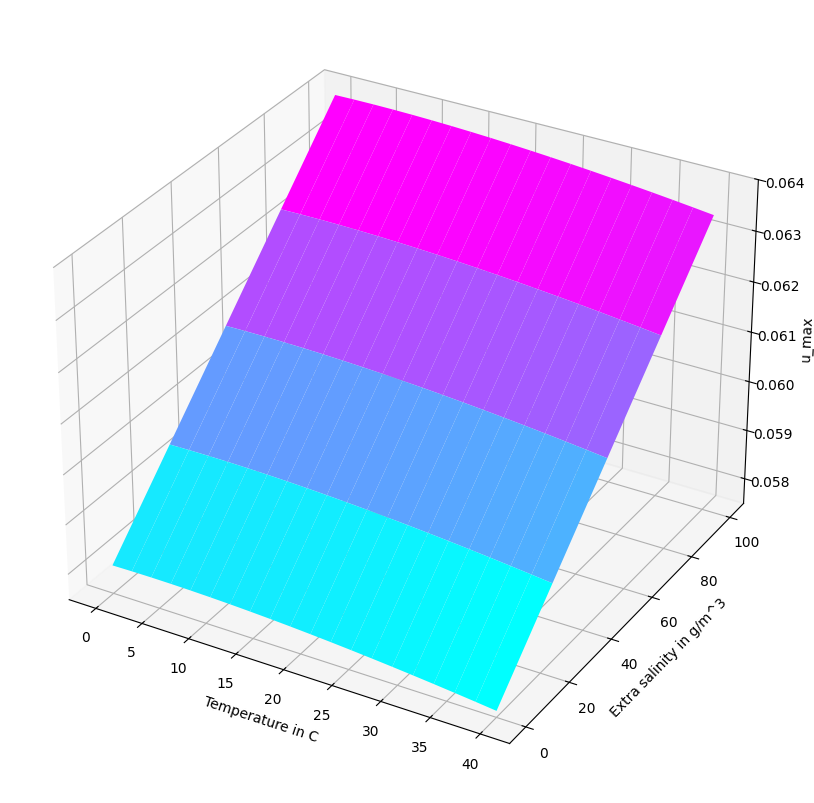

In [89]:
DT_DS_UMAX_Diagram()

#DT_UMAX_diagram()

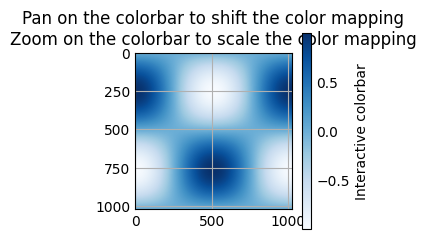

In [105]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 2 * np.pi, 1024)
data2d = np.sin(t)[:, np.newaxis] * np.cos(t)[np.newaxis, :]

fig, ax = plt.subplots()
im = ax.imshow(data2d)
ax.set_title('Pan on the colorbar to shift the color mapping\n'
             'Zoom on the colorbar to scale the color mapping')

fig.colorbar(im, ax=ax, label='Interactive colorbar')

plt.show()